In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


# Preprocessing

In [6]:
beh_cols = get_behaviour_cols()
df_pca_input = get_preprocessed_data(impute=True, impute_cols=beh_cols)

In [31]:
scaler = MinMaxScaler()
pca_input = scaler.fit_transform(df_pca_input[beh_cols].to_numpy())
pca_input.shape

(123230, 23)

# PCA

In [37]:
pca = PCA(whiten=True)
x_pca = pca.fit_transform(pca_input)
df_pca = pd.DataFrame(x_pca)
for column in df_pca.columns:
  df_pca.rename(columns={column: 'PC_'+str(column)}, inplace=True)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22
0,-0.434335,-0.223732,-0.240509,-0.258341,0.351749,0.006769,0.107871,-0.273086,-0.062490,0.222961,...,-0.265460,-0.014869,0.029733,0.124997,-0.047784,-0.038103,-0.042267,0.011987,0.006619,0.079820
1,-0.736331,-0.132329,-0.179533,-0.314854,0.071059,-0.346478,-0.465221,0.246890,0.043862,0.076761,...,0.026120,-0.145648,-0.007360,0.105513,0.036527,0.010652,0.087560,0.147484,-0.076578,0.047202
2,-0.754406,0.152623,0.148076,0.532508,-0.337626,-0.078483,-0.223338,0.072501,0.408530,0.042416,...,-0.046759,-0.135497,0.043068,0.027590,0.269606,-0.023366,-0.238308,-0.132815,0.022716,-0.027740
3,-0.610206,0.016363,0.464969,-0.090197,0.537031,0.478387,0.392734,-0.434215,-0.445998,0.096336,...,0.075721,0.069382,-0.024201,0.165832,-0.027591,0.015093,-0.022726,0.072923,0.110761,0.025359
4,0.102406,-0.666096,0.552092,0.699626,0.410284,0.096322,-0.561797,0.326299,0.070234,-0.236242,...,-0.663648,-0.596679,0.207106,-0.532670,0.439936,0.176367,0.066790,-0.529351,0.195440,0.003797


# Evaluate Results

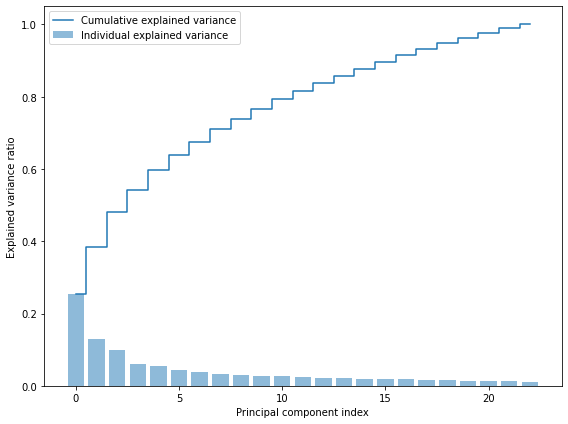

In [38]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

In [39]:
num_comp_avg = (exp_var_pca > exp_var_pca.mean()).sum()
explained_variance = cum_sum_eigenvalues[num_comp_avg-1]
print(f'{num_comp_avg} Komponenten sind größer als der Durchschnitt und erklären damit {np.round(explained_variance * 100, 2)}% der Varianz in den Daten.')

5 Komponenten sind größer als der Durchschnitt und erklären damit 59.6% der Varianz in den Daten.


Die Dimensionen sollen soweit reduziert werden, dass noch 80% der Varianz benötigt werden.

In [35]:
nr_pc_80 = (cum_sum_eigenvalues<=0.8).sum()
print(nr_pc_80,  ' Werte erklären 80% der Daten.')

11  Werte erklären 80% der Daten.


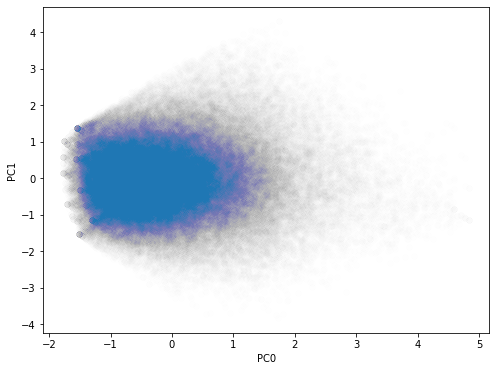

In [36]:
plt.scatter(x=df_pca['PC_0'], y=df_pca['PC_1'], alpha=0.005)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

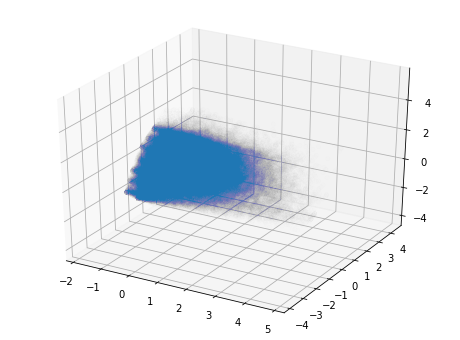

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_pca['PC_0'], df_pca['PC_1'], df_pca['PC_2'], alpha=0.005)

# Write Data

In [41]:
col_names = df_pca.iloc[:,:nr_pc_80].columns.tolist()
df_pca_write = pd.concat([df_pca.iloc[:,:nr_pc_80].copy(), df_pca_input], axis=1)
df_pca_write.dropna(subset=col_names, inplace=True)
df_pca_write.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123230 entries, 0 to 123229
Data columns (total 90 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   PC_0                                           123230 non-null  float64
 1   PC_1                                           123230 non-null  float64
 2   PC_2                                           123230 non-null  float64
 3   PC_3                                           123230 non-null  float64
 4   PC_4                                           123230 non-null  float64
 5   PC_5                                           123230 non-null  float64
 6   PC_6                                           123230 non-null  float64
 7   PC_7                                           123230 non-null  float64
 8   PC_8                                           123230 non-null  float64
 9   PC_9                                 

In [ ]:
df_pca_write.to_csv('data/preprocessing/dim_reduction/220422_pca_data.csv', index=False)

# Evaluate PCA Components

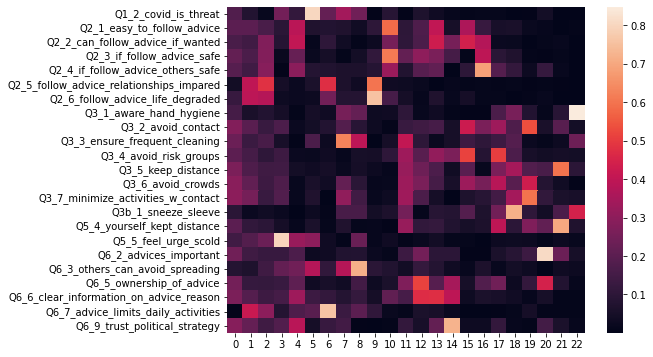

In [76]:
import seaborn as sns
df_components = pd.DataFrame(pca.components_, columns=beh_cols).transpose()
df_components = df_components.apply(lambda x: np.abs(x))
sns.heatmap(df_components) # .iloc[:,:nr_pc_80]